Install necesary libraries

In [ ]:
!pip install -U textblob
!pip install textblob-nl
!python -m textblob.download_corpora

In [150]:
import pandas as pd

data = pd.read_csv (r'cleaned_tweets.csv')
pd.Series(data['tweet_id']).is_unique

True

In [151]:
from tqdm.notebook import tqdm
tqdm.pandas()

sentiment = data.clean_text.progress_apply(lambda x: tuple(TextBlob(text=x, analyzer=PatternAnalyzer()).sentiment))

data["polarity"] = sentiment.str.get(0)
data["subjectivity"] = sentiment.str.get(1)

  0%|          | 0/11690 [00:00<?, ?it/s]

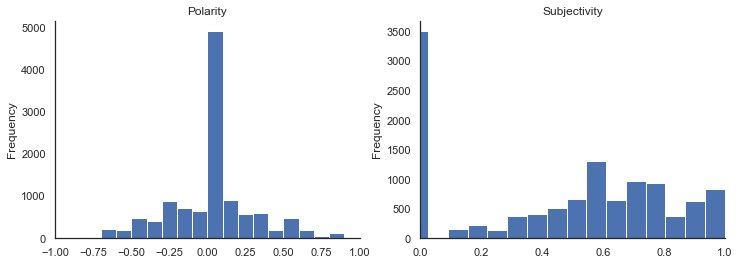

In [152]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

fig, ax = plt.subplots(figsize=(12, 4), ncols=2)

data["polarity"].plot(kind="hist", ax=ax[0], bins=20, edgecolor="white",  title="Polarity")
data["subjectivity"].plot(kind="hist",ax=ax[1], bins=20, edgecolor="white", title="Subjectivity")

ax[0].set_xlim(-1, 1)
ax[1].set_xlim(0, 1)

# Meta-data plot
sns.despine()

In [153]:
data["polarity_text"] = 0

data.loc[data.polarity > 0, 'polarity_text'] = 'Positive'
data.loc[data.polarity < 0, 'polarity_text'] = 'Negative'
data.loc[data.polarity == 0, 'polarity_text'] = 'Neutral'

Text(0.5, 0.98, 'Sentiment of tweets')

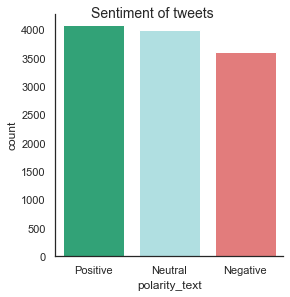

In [154]:
fc = sns.catplot(x="polarity_text",
                    data=data, kind="count", 
                    palette={"Negative": "#F36B6B", 
                             "Positive": "#1FB57B", 
                             "Neutral": "#A8E7E9"},
                    height=4, aspect=1)
fc.fig.suptitle('Sentiment of tweets', fontsize=14)

In [155]:
pos = data[data.polarity == 1].index[0]
print("Most positive tweet:")
print(data.iloc[pos]["text"])

neg = data[data.polarity == -1].index[0]
print("Most negative tweet:")
print(data.iloc[neg]["text"])

neu = data[data.polarity == 0].index[2]
print("Neutral tweet example:")
print(data.iloc[neu]["text"])

Most positive tweet:
RT @BasedMadocke: Een perfect antwoord op het cultuurterrorisme van Kozp. #kozp #Volendam
Most negative tweet:
Belachelijk dat de politie in Volendam demonstranten niet beschermt tegen geweld. #kozp #ZwartePietIsRacisme
Neutral tweet example:
RT @rallyjef2: Iemand een visschotel besteld?

#volendam #kozp #bij1 #SylvanaSimons #pvv #dvd #sinterklaas https://t.co/NYIi9QUevv
